In [1]:
from __future__ import print_function
import glob
from itertools import chain
import os
import random
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import math
from vit_pytorch.efficient import ViT
import cv2
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import requests

In [2]:
batch_size = 64
epochs = 8
lr = 3e-5
gamma = 0.7
seed = 142
IMG_SIZE = 224

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dir = '/workspace/kbqa/subgraph_plots/nx/training/'
test_dir = '/workspace/kbqa/subgraph_plots/nx/validation/'

train_list = glob.glob(os.path.join(train_dir + 'correct/','*.png')) + glob.glob(os.path.join(train_dir + 'wrong/','*.png'))
test_list = glob.glob(os.path.join(test_dir + 'correct/', '*.png')) + glob.glob(os.path.join(test_dir + 'wrong/','*.png'))

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

labels = ['correct', 'wrong']

Train Data: 577
Test Data: 246


Train Data: 368
Validation Data: 93
Test Data: 246


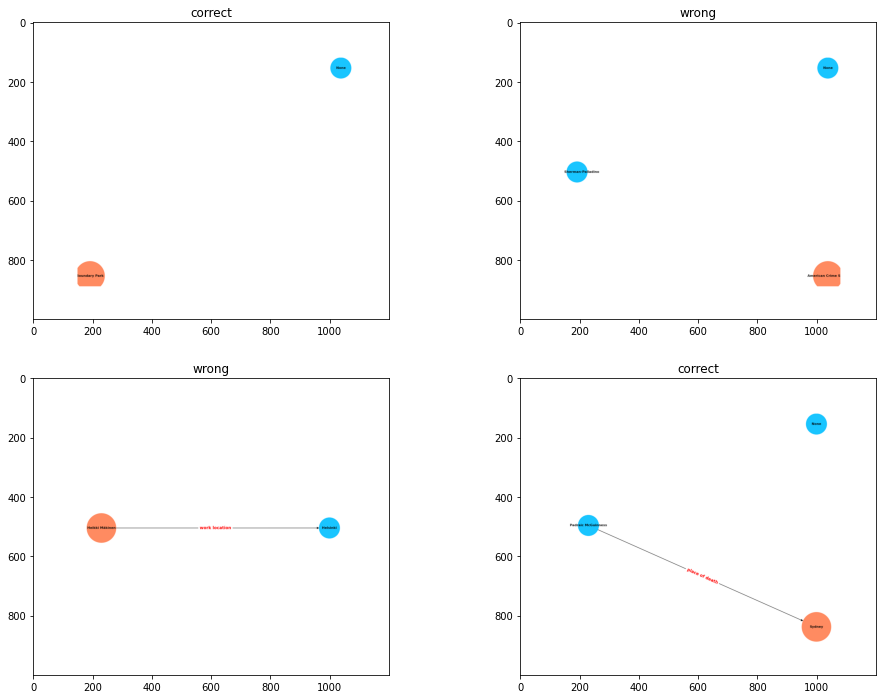

In [6]:
# display images from train set

random_idx = np.random.randint(1, len(train_list), size=4)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, ax in zip(random_idx, axes.ravel()):
    img = Image.open(train_list[idx])
    if 'correct' in train_list[idx]:
        ax.set_title('correct')
    else:
        ax.set_title('wrong')
    ax.imshow(img)

train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          random_state=seed)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

In [7]:
# ### Image Augmentation

#Tune the transforms
ORIG_RES = False

if ORIG_RES:
    resize = 512
else:
    resize = 224

train_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


class CorrectWrongDataset(Dataset):
    def __init__(self, file_list, transform=None, orig_res=False):
        if orig_res:
            self.IMG_SIZE = 512
        else:
            self.IMG_SIZE = 224
        
        self.file_list = file_list
        self.transform = transform
        self.orig_res = orig_res
 
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB')
        img_transformed = self.transform(img)
        
        if 'correct' in img_path:
            label = 1
        else:
            label = 0
        
        return img_transformed, label

train_data = CorrectWrongDataset(train_list, transform=train_transforms, orig_res = ORIG_RES)
valid_data = CorrectWrongDataset(valid_list, transform=test_transforms, orig_res = ORIG_RES)
test_data = CorrectWrongDataset(test_list, transform=test_transforms, orig_res = ORIG_RES)

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [8]:
def class_weights(train_list):

    """
    functions to get weights for model training of unbalanced classes
    """
    correct_count = 0
    wrong_count = 0
    
    for train_plot in train_list:
        if 'correct' in train_plot:
            correct_count+=1
        else:
            wrong_count+=1

    correct_weight = (correct_count + wrong_count) / (
        2 * correct_count
    )  # division by 2 due to binary class
    wrong_weight = (correct_count + wrong_count) / (2 * wrong_count)

    # 1 is our correct label and 0 is incorrect
    return [correct_weight, wrong_weight]

In [9]:
efficient_transformer = Linformer(
    dim=128,#128
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
   channels=3,
).to(device)


# loss function
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights(train_list)))
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
        for data, label in valid_loader:
            
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6651 - acc: 0.5651 - val_loss : 0.6337 - val_acc: 0.6166



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6406 - acc: 0.6059 - val_loss : 0.6259 - val_acc: 0.5884



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6179 - acc: 0.6007 - val_loss : 0.6112 - val_acc: 0.6166



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6173 - acc: 0.6016 - val_loss : 0.6185 - val_acc: 0.5978



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6226 - acc: 0.6024 - val_loss : 0.6287 - val_acc: 0.5884



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6243 - acc: 0.5938 - val_loss : 0.6254 - val_acc: 0.5884



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6191 - acc: 0.5981 - val_loss : 0.6255 - val_acc: 0.5884



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6192 - acc: 0.5998 - val_loss : 0.6185 - val_acc: 0.5978



In [10]:
# performance on test data

def test(model, test_loader, criterion):
    '''
    Model testing 
    
    Args:
        model: model used during training and validation
        test_loader: data loader object containing testing data
        criterion: loss function used
    
    Returns:
        test_loss: calculated loss during testing
        accuracy: calculated accuracy during testing
        y_proba: predicted class probabilities
        y_truth: ground truth of testing data
    '''
    
    y_proba = []
    y_truth = []
    logits = torch.empty((len(test_list), 2))
    test_loss = 0
    total = 0
    correct = 0
    for data in tqdm(test_loader):
        X, y = data[0].to(device), data[1].to(device)
        output = model(X)
        torch.cat((logits, output), dim = 0)
        test_loss += criterion(output, y.long()).item()
        for index, i in enumerate(output):
            y_proba.append(i[1])
            y_truth.append(y[index])
            if torch.argmax(i) == y[index]:
                correct+=1
            total+=1
                
    accuracy = correct/total
    
    y_proba_out = np.array([float(y_proba[i]) for i in range(len(y_proba))])
    y_truth_out = np.array([float(y_truth[i]) for i in range(len(y_truth))])
    
    return test_loss, accuracy, y_proba_out, y_truth_out, logits


loss, acc, y_proba, y_truth, logits = test(model, test_loader, criterion = nn.CrossEntropyLoss())


print(f"Accuracy: {acc}")

print(pd.value_counts(y_truth))

  0%|          | 0/4 [00:00<?, ?it/s]

Accuracy: 0.5934959349593496
0.0    146
1.0    100
dtype: int64


In [12]:
y_pred = torch.argmax(logits, dim = -1).numpy()

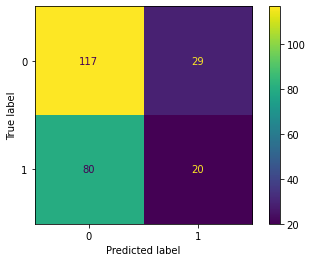

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_mat = confusion_matrix(y_truth, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()

In [14]:
from sklearn.metrics import f1_score
print(f1_score(y_truth, y_pred))

0.26845637583892623
